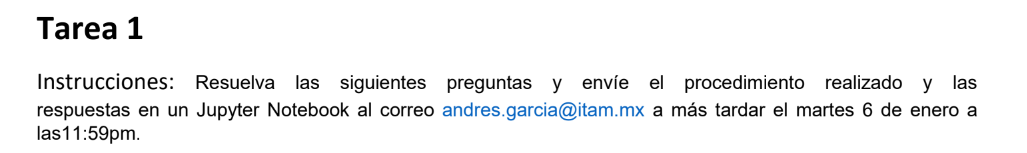


Librerias

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

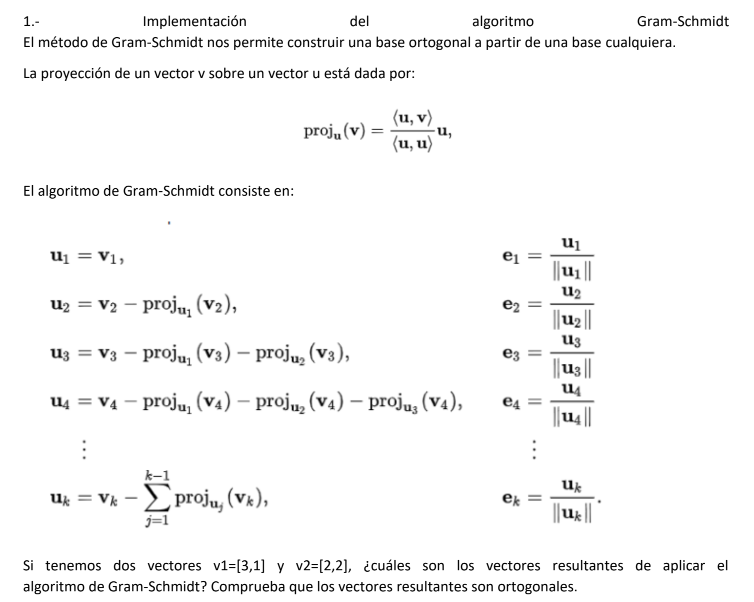

In [2]:
def proy(prev_u, v):
    return (np.dot(prev_u, v) / np.dot(prev_u, prev_u)) * prev_u

def gram_schmidt(vectors):
    vectors = [np.array(v, dtype=float) for v in vectors]
    ortho = []

    for v in vectors:
        u = v.copy()
        for prev_u in ortho:
            proj = proy(prev_u, v)
            u -= proj
        ortho.append(u)

    return ortho

V = [[3, 1], [2, 2]]
U = gram_schmidt(V)

for i, u in enumerate(U):
    print(f"u{i+1} =", u)

producto_punto = np.dot(U[0], U[1])

print("Producto punto =", producto_punto)

u1 = [3. 1.]
u2 = [-0.4  1.2]
Producto punto = -1.1102230246251565e-15


2. Suponiendo que contamos con los siguiente YTM de bonos (tasa fija, freq pago cupón semestral), obtén los
factores de descuento y las tasas cero en composición continua que resultan del bootstrapping.

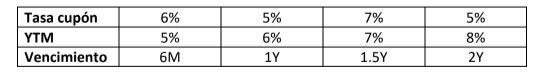

In [3]:

'''
YTM es una tasa promedio (Es la tasa constante que iguala el precio de un bono con el valor presente de todos sus flujos a futuro).
Otra definición: El YTM es la tasa única que iguala el precio actual de un bono con el valor presente de todos sus pagos futuros.
Un factor de descuento D(T) responde la pregunta: ¿Cuánto vale hoy $1 que recibiré en el tiempo T?


'''

'''
Sí conozco los factores de descuento de los flujos tempranos, puedo despejar el factor de descuento del último flujo

'''


def bootstrap_zero_curve(coupons, ytms, maturities, freq=2, face=100):
    """
    coupons     : lista de cupones anuales (ej. 0.06)
    ytms        : lista de YTM anuales (ej. 0.05)
    maturities  : lista de vencimientos en años (ej. 1.5)
    freq        : frecuencia de cupón (default 2)
    face        : valor nominal
    """

    # ordenar por vencimiento
    data = sorted(zip(maturities, coupons, ytms)) #Ordenamos por vencimiento
    
    discount_factors = {}
    zero_rates_cc = {}

    for T, c, y in data:
        n = int(T * freq)
        coupon = c * face / freq
        ytm = y / freq

        # precio usando YTM
        price = 0
        for t in range(1, n + 1):
            cf = coupon if t < n else coupon + face
            price += cf / (1 + ytm) ** t

        # bootstrapping
        known_cf = 0
        for t in range(1, n):
            ti = t / freq
            known_cf += coupon * discount_factors[ti]

        D_T = (price - known_cf) / (coupon + face)
        discount_factors[T] = D_T

        # tasa cero continua
        zero_rates_cc[T] = -np.log(D_T) / T

    return discount_factors, zero_rates_cc


coupons = [0.06, 0.05, 0.07, 0.05]
ytms = [0.05, 0.06, 0.07, 0.08]
maturities = [0.5, 1.0, 1.5, 2.0]

dfs, zeros = bootstrap_zero_curve(coupons, ytms, maturities)

for T in dfs:
    print(f"T={T}  D(T)={dfs[T]:.5f}  r_cc={zeros[T]*100:.2f}%")


T=0.5  D(T)=0.97561  r_cc=4.94%
T=1.0  D(T)=0.94248  r_cc=5.92%
T=1.5  D(T)=0.90132  r_cc=6.93%
T=2.0  D(T)=0.85372  r_cc=7.91%


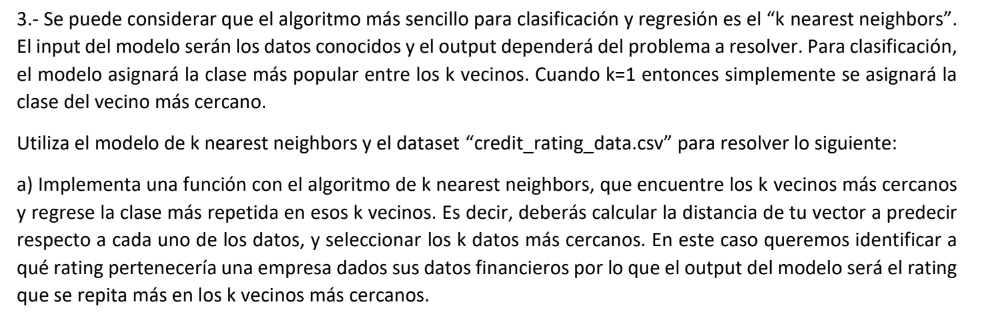

In [4]:
#y es nuestro vector de etiquetas
def knn_predict(x, y, xc, k):
    d = np.linalg.norm(x - xc, axis=1)
    vecinos = np.argsort(d)[:k]
    votos = y[vecinos]
    return Counter(votos).most_common(1)[0][0]

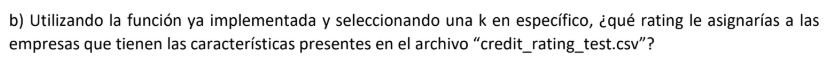

In [5]:
train = pd.read_csv("credit_rating_data.csv") 
test = pd.read_csv("credit_rating_test.csv")

#Practicamente tenemos nuestro sample de informacion, y lo que queremos es con campos muy similares asignarles un rating. 

#Defino las variables a utilizar para cada punto del vector (Sí lo queremos llamar de esa forma)
features = ["Cash", "Total debt/total asset", "Employees","Revenue - Total","Net Cash Flow"]

x = train[features].values #Aqui jalo todos los valores de mis pts (Quito los campos que no necesito)
y = train["Rating"].values #Jalo el valor de rating solito que va ser mi referencia para asignar
xc = test[features].values

scaler = StandardScaler() #Objeto para darle el mismo peso a todos
x = scaler.fit_transform(x)
xc = scaler.transform(xc)

k = 5
predicciones = []
for x_test in xc: #Iteras sobre xc porque son los campos que comparten en comun el test con el train
    predicciones.append(knn_predict(x, y, x_test, k))
test["rating_asignado"] = predicciones
print(predicciones)



['Investment Grade', 'Speculative', 'Investment Grade', 'Speculative', 'Speculative', 'Speculative', 'Speculative', 'Speculative', 'Speculative', 'Speculative', 'Speculative', 'Speculative', 'Speculative', 'Speculative', 'Speculative', 'Speculative', 'Speculative', 'Speculative', 'Investment Grade', 'Speculative', 'Investment Grade', 'Investment Grade', 'Speculative', 'Speculative', 'Speculative', 'Investment Grade', 'Investment Grade', 'Investment Grade', 'Speculative', 'Speculative', 'Investment Grade', 'Investment Grade', 'Speculative', 'Investment Grade', 'Speculative', 'High Risk', 'Speculative', 'Investment Grade', 'Investment Grade', 'Speculative', 'Speculative', 'Investment Grade', 'Investment Grade', 'Speculative', 'Speculative', 'Speculative', 'Investment Grade', 'Speculative', 'Speculative', 'Speculative', 'Speculative', 'Speculative', 'Speculative', 'Investment Grade', 'Speculative', 'Investment Grade', 'Investment Grade', 'Speculative', 'Speculative', 'Speculative', 'Inves

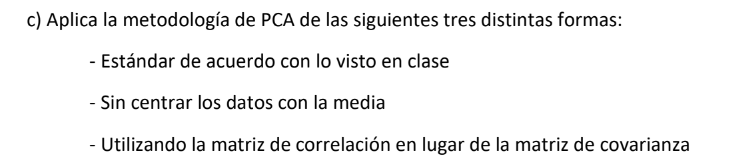

In [6]:
# El objetivo del PCA es encontrar nuevas variables que sean combinaciones lineales de los features originales, no sean correlacionadas
# Seleccionar features
"""
    Para entender esta pregunta es necesario conocer el concepto de varianza, cómo el PCA identifica direcciones de máxima variabilidad mediante combinaciones lineales de las variables originales, 
    la importancia del centrado y escalado de los datos, y cómo interpretar los componentes principales y sus proyecciones gráficas. 
    Asimismo, es fundamental comprender cómo la reducción de dimensionalidad facilita la visualización y mejora el desempeño de algoritmos basados en distancias como kNN.
"""


features = ["Cash", "Total debt/total asset", "Employees","Revenue - Total","Net Cash Flow"]

x = train[features].values

#Inciso c.1)
mu = np.mean(x, axis=0) #Calculo la media de mis columnas
x_centered = x - mu #Resto la media
#La matriz de covarianza contiene las covarianzas de cada variable con todas las demás variables, incluida consigo misma.
cov = np.cov(x_centered, rowvar=False)
#Los vectores propios te dicen en qué direcciones mirar los datos.
#Los valores propios te dicen qué tan importante es cada dirección.
valores_propios, vectores_propios = np.linalg.eig(cov)
# 5. ORDENAR por varianza explicada (CLAVE)
idx = np.argsort(valores_propios)[::-1]
valores_propios = valores_propios[idx]
vectores_propios = vectores_propios[:, idx]
# 6. Proyección (PCA)
X_pca = x_centered @ vectores_propios


#Inciso c.2)

# 1. Matriz de covarianza SIN centrar
cov_no_center = np.cov(x, rowvar=False)

# 2. Eigendescomposición
valores_propios_nc, vectores_propios_nc = np.linalg.eig(cov_no_center)

# 3. Ordenar por varianza explicada
idx_nc = np.argsort(valores_propios_nc)[::-1]
valores_propios_nc = valores_propios_nc[idx_nc]
vectores_propios_nc = vectores_propios_nc[:, idx_nc]

# 4. Proyección
X_pca_no_center = x @ vectores_propios_nc

#Inciso c.3)
sigma = np.std(x, axis=0)
x_std = (x - mu) / sigma

# 2. Matriz de correlación
corr = np.corrcoef(x_std, rowvar=False)

# 3. Eigendescomposición
valores_propios_corr, vectores_propios_corr = np.linalg.eig(corr)

# 4. Ordenar por varianza explicada
idx_corr = np.argsort(valores_propios_corr)[::-1]
valores_propios_corr = valores_propios_corr[idx_corr]
vectores_propios_corr = vectores_propios_corr[:, idx_corr]

# 5. Proyección
X_pca_corr = x_std @ vectores_propios_corr

d Grafica los primeros dos componentes principales obtenidos de los 3 casos anteriores. Luego, gráfica en 2D
todos los pares posibles de los features en el dataset.

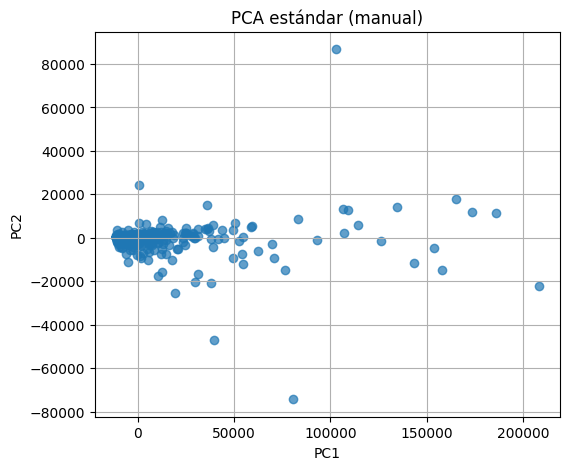

In [7]:
plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA estándar (manual)")
plt.grid()
plt.show()

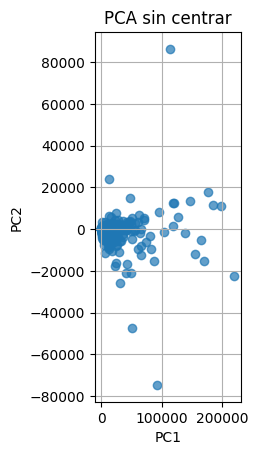

In [8]:
plt.subplot(1,3,2)
plt.scatter(X_pca_no_center[:,0], X_pca_no_center[:,1], alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA sin centrar")
plt.grid()

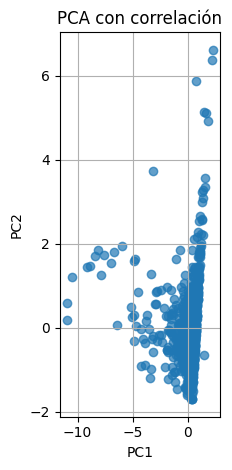

In [9]:
plt.subplot(1,3,3)
plt.scatter(X_pca_corr[:,0], X_pca_corr[:,1], alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA con correlación")
plt.grid()
plt.tight_layout()
plt.show()

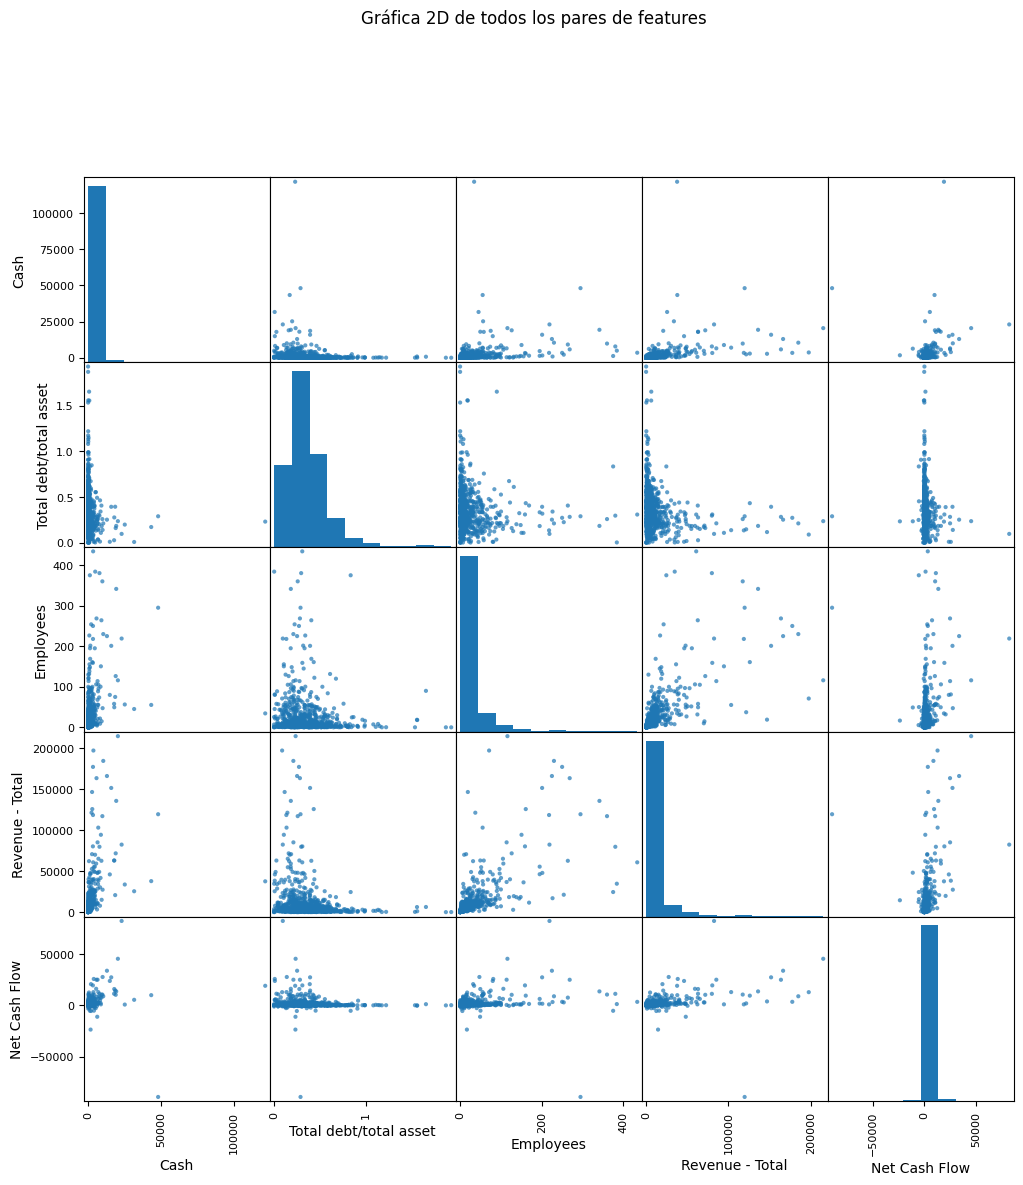

In [10]:
features = ["Cash", "Total debt/total asset", "Employees","Revenue - Total","Net Cash Flow"]
pd.plotting.scatter_matrix(
    train[features],
    figsize=(12,12),
    diagonal="hist",
    alpha=0.7
)

plt.suptitle("Gráfica 2D de todos los pares de features", y=1.02)
plt.show()

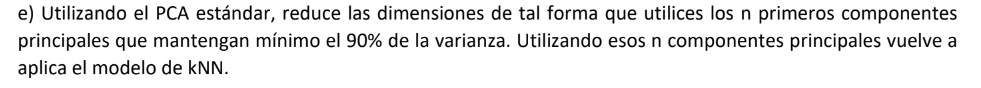

In [11]:
# Varianza explicada por componente
varianza_explicada = valores_propios / np.sum(valores_propios)

# Varianza acumulada
varianza_acumulada = np.cumsum(varianza_explicada)

print("Varianza explicada acumulada:")
for i, v in enumerate(varianza_acumulada):
    print(f"PC1 a PC{i+1}: {v:.4f}")


n = np.where(varianza_acumulada >= 0.90)[0][0] + 1
print("Número de componentes para 90% de varianza:", n)

# Reduccción dimensional
W_n = vectores_propios[:, :n]

# Datos de entrenamiento reducidos
X_pca_90 = x_centered @ W_n



Varianza explicada acumulada:
PC1 a PC1: 0.9108
PC1 a PC2: 0.9581
PC1 a PC3: 1.0000
PC1 a PC4: 1.0000
PC1 a PC5: 1.0000
Número de componentes para 90% de varianza: 1


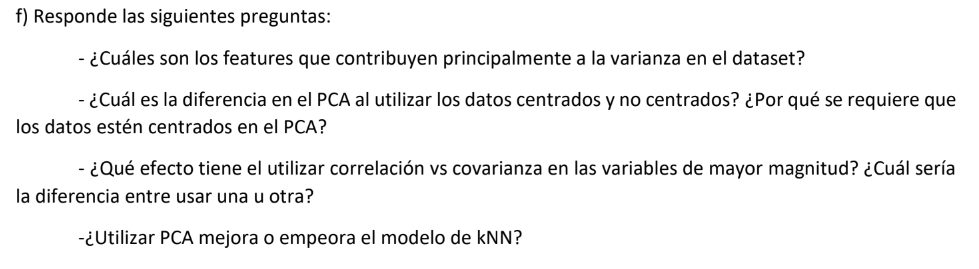

R1 = A partir del análisis visual de los pares de variables y de la dispersión observada, los features que contribuyen principalmente a la varianza del dataset son:

Revenue – Total, que presenta el mayor rango de valores y una alta dispersión, además de valores extremos.

Cash, con una distribución altamente sesgada y algunos valores muy elevados.

Employees, que muestra variabilidad significativa y una relación positiva con Revenue.

En contraste, Total debt / total asset presenta una dispersión reducida y contribuye en menor medida a la varianza total, mientras que Net Cash Flow aporta una varianza intermedia.

Orden aproximado de contribución a la varianza (sin estandarizar):
Revenue – Total > Cash > Employees > Net Cash Flow > Total debt / total asset

R2 = Sí los datos no están centrados, el PCA captura la variabilidad con respecto al origen. Cuando los datos están centrados, cada varaible tiene media cero y el PCA identifica las direcciones de máxima variabilidad alrededor del promedio.

R3 = La matriz de covarianza hace que las variables con mayor escala dominen los componentes principales. La matriz de correlación equivale a estandarizar las variables, otorgando el mismo peso a todas. En datasets con variables de distintas esacalas; es preferible utilizar la matriz de correlación.

R4 = PCA tienda a mejorar el desempeño de kNN cuando se selecciona un número adecuado de componentes y se valida su impacto mediante pruebas. 